This notebook is used for a demo code of convolutional forward model

In [36]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [37]:
import platform
platform.platform()

'macOS-13.1-arm64-i386-64bit'

In [40]:
device = torch.device("cpu")

In [41]:
import sys
print("Python version")
print (sys.version)
print("Version info.")
print (sys.version_info)

Python version
3.9.16 (main, Jan 11 2023, 10:02:19) 
[Clang 14.0.6 ]
Version info.
sys.version_info(major=3, minor=9, micro=16, releaselevel='final', serial=0)


Align the PSFs according to the position where chief rays land on the sensor

In [42]:
def register(h, c):
    meas_dim = h.size()[0]
    half_size = int(meas_dim // 2)
    max_sft = int(torch.max(torch.abs(c)).item())
    h_reg = torch.zeros(h.size()[0] + 2 * max_sft, h.size()[1], dtype=torch.float)
    for i in range(len(v)):
        pivot = int(max_sft - c[i])
        #print (pivot, meas_dim, i)
        h_reg[pivot:pivot+meas_dim, i] = h[:, i]
    return h_reg

In [43]:
def fft_conv(g, v2):
    G = torch.fft.fft(g)
    V2 = torch.fft.fft(v2)
    m = torch.real(torch.fft.ifftshift(torch.fft.ifft(G * V2)))
    return m

In [44]:
def fill(c, v):
    max_sft = int(torch.max(torch.abs(c)).item())
    fill_c = torch.arange(-max_sft, max_sft + 1)
    fill_v = torch.zeros_like(fill_c, dtype=torch.float)
    for i in range(len(c)):
        idx = torch.where(fill_c == c[i])
        fill_v[idx] = v[i]
    return fill_c, fill_v

In [45]:
def tri_func(interval):
    idx = torch.arange(0, 2 * (interval + 1) + 1, dtype=torch.float64)
    cent = interval + 1
    tri = 1 - torch.abs(idx - cent) / (interval + 1)
    return tri

sp tensor([0., 3., 6.])


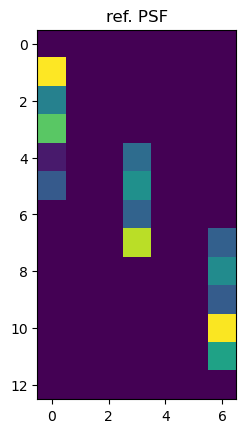

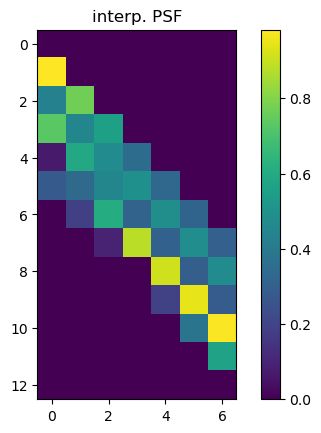

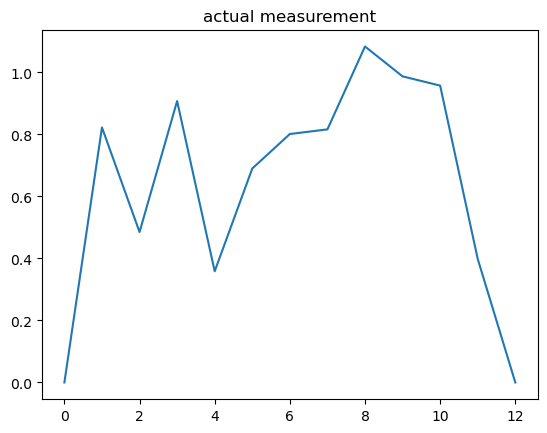

In [46]:
if __name__ == '__main__':
    torch.random.manual_seed(5566)
    meas_dim = 13
    cent = int(meas_dim // 2)
    v_dim = 7
    f_dim = 5
    K = 5
    interval = 2 # the gap between two sampled points
    step = int((v_dim - 1) / (interval + 1)) + 1
    sp = torch.linspace(0, v_dim-1, step)
    print ('sp', sp)
    v = torch.rand(v_dim, dtype=torch.float)
    f = torch.rand(f_dim, v_dim, dtype=torch.float)
    #v = torch.tensor([1., 3., 5., 2., 4.]) # brightness
    v_r = v[None, :].repeat(v.size()[0], 1)
    c = torch.linspace(-(v_dim//2), v_dim//2, v_dim)
    tri = tri_func(interval)
    #print (tri)
    #c = torch.tensor([-3, -1, 0, 1, 3]) # chief ray

    # insert dummy point if not unit magnification
    um_c = torch.arange(len(c)) - len(c) // 2
    if not (um_c == c).all():
        c, v = fill(c, v)
    #v[:v_dim-1] = 0.
    #v[v_dim-1] = 1.
    #f[:, 1:] = 0.
    v_r = v[None, :].repeat(v.size()[0], 1)
    #print (c, v, f)

    h_ref = torch.zeros(meas_dim, len(v), dtype=torch.float)
    meas = torch.zeros(meas_dim)
    for i in range(len(v)):
        if i in sp:
            h_ref[int(c[i]+cent-f_dim//2):int(c[i]+cent+f_dim//2+1), i] = f[:, i]

    # interpolation
    h = torch.zeros(meas_dim, len(v), dtype=torch.float)
    for i in range(len(v)):
        if i in sp:
            h[int(c[i]+cent-f_dim//2):int(c[i]+cent+f_dim//2+1), i] = f[:, i]
        else:
            prev_idx = int(i // (interval + 1)) * (interval + 1)
            next_idx = (int(i // (interval + 1)) + 1) * (interval + 1)
            alpha = int(i % (interval + 1)) / (interval + 1)
            h[int(c[i]+cent-f_dim//2):int(c[i]+cent+f_dim//2+1), i] = (1 - alpha) * f[:, prev_idx] + alpha * f[:, next_idx]
            #print (i, alpha, prev_idx, next_idx)
            #print (h[int(c[i]+cent-f_dim//2), i], f[0, prev_idx], f[0, next_idx])
    meas = h @ v
    h_reg = register(h, c)
    new_cent = int(h_reg.size()[0] // 2)
    half_vlen = int(len(v) // 2)
    
    plt.imshow(h_ref.numpy())
    plt.title('ref. PSF')
    plt.show()
    plt.close()
    
    plt.imshow(h.numpy())
    plt.title('interp. PSF')
    plt.colorbar()
    plt.show()
    plt.close()

    plt.plot(meas.numpy())
    plt.title('actual measurement')
    plt.show()
    plt.close()

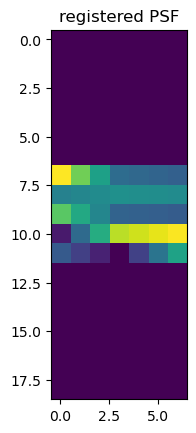

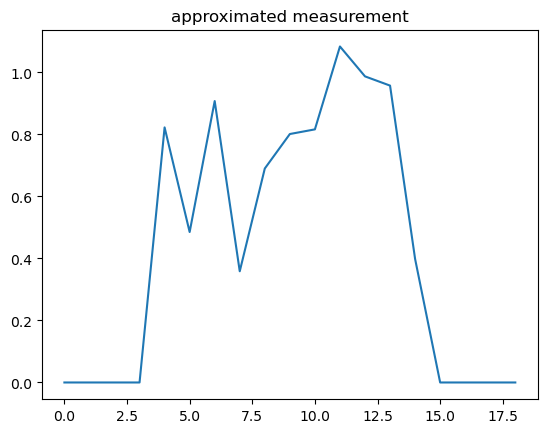

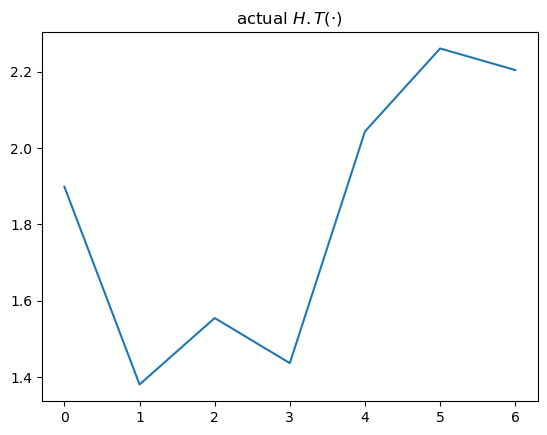

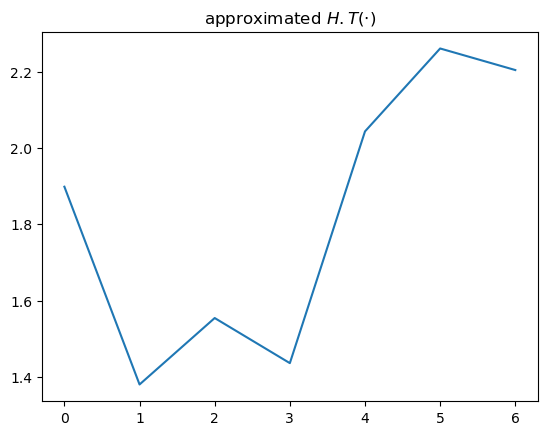

In [47]:
    
    # windowed convolution
    meas_test = torch.zeros(h_reg.size()[0], dtype=torch.float)
    pad_size = (h_reg.size()[0] - v_dim) / 2
    v_pad = torch.zeros(h_reg.size()[0], dtype=torch.float)
    v_pad[new_cent-half_vlen:new_cent+half_vlen+1] = v
    #print (pad_size, sp, v_pad)
    for i in range(len(sp)):
        weights = torch.zeros_like(v_pad)
        start_idx = int(sp[i] + pad_size - (interval + 1))
        end_idx = int(sp[i] + pad_size + (interval + 2))
        weights[start_idx:end_idx] = tri
        wv = v_pad * weights
        meas_test += fft_conv(h_reg[:, int(sp[i])], wv)

    # FFT method
    g, s, w = torch.svd(h_reg)
    w2 = torch.diag(s) @ w.T
    h_rec = g[:, 0].view(h_reg.size()[0], 1) @ w2[0, :].view(1, len(v))
    meas_fft = torch.zeros(g.size()[0], dtype=torch.float)
    for i in range(K):
        v2 = (w2 * v_r)[i, :]
        v2_pad = torch.zeros(h_reg.size()[0], dtype=torch.float)
        v2_pad[new_cent-half_vlen:new_cent+half_vlen+1] = v2
        meas_fft += fft_conv(g[:, i], v2_pad)
        #print (g.size(), v2_pad.size())

    # adj matrix
    half_meas_len = meas_dim // 2
    meas_test_crop = meas_test[new_cent-half_meas_len:new_cent+half_meas_len+1]
    actual_product = h.T @ meas_test_crop
    meas_test_flip = torch.flip(meas_test, dims=(0,))
    #print (h_reg[:, 0], meas_test, meas_test_flip)
    #print (h.T[0, :], meas_test_crop, h.size(), meas_test.size(), meas_test_crop.size())
    #print (actual_product)

    est = torch.zeros(h.size()[1], dtype=torch.float)
    for i in range(len(sp)):
        weights = torch.zeros_like(v_pad)
        start_idx = int(sp[i] + pad_size - (interval + 1))
        end_idx = int(sp[i] + pad_size + (interval + 2))
        weights[start_idx:end_idx] = tri
        weights[0:int(pad_size)] = 0.
        weights[-int(pad_size):] = 0.
        h_reg_idx = int(h_reg.size()[1] - 1 - sp[i])
        est += (weights * fft_conv(h_reg[:, h_reg_idx], meas_test_flip))[int(pad_size):-int(pad_size)]
        #print (weights, weights * est, sp[i], h_reg.size())
    #print (est)

    #plt.imshow(h.numpy().T)
    #plt.colorbar()
    #plt.show()
    #plt.close()


    plt.imshow(h_reg.numpy())
    plt.title('registered PSF')
    plt.show()
    plt.close()

    #plt.plot(meas_fft.numpy())
    #plt.show()
    #plt.close()

    plt.plot(meas_test.numpy())
    plt.title('approximated measurement')
    plt.show()
    plt.close()

    plt.plot(actual_product.numpy())
    plt.title('actual $H.T(\cdot)$')
    plt.show()
    plt.close()

    plt.plot(np.flip(est.numpy()))
    plt.title('approximated $H.T(\cdot)$')
    plt.show()
    plt.close()

In [48]:
# Test FFT speed on pytorch GPU
test = np.random.randn(1024,1024).astype(np.float64)
tt = torch.tensor(test)

In [49]:
%%time
for ii in range(1000):
    torch.fft.rfft2(tt)

CPU times: user 3.47 s, sys: 20.7 ms, total: 3.49 s
Wall time: 3.5 s


In [12]:
print(tt)

tensor([[-0.9685, -0.4986,  0.7429,  ..., -0.6576,  0.0246,  0.2978],
        [ 0.0932,  0.5991,  0.8190,  ..., -0.5182,  0.8703, -1.1118],
        [-0.4351, -0.1478, -0.8588,  ...,  0.1655, -0.9569, -0.5192],
        ...,
        [-1.0072, -0.3082, -0.8975,  ...,  0.7594, -1.7756,  0.3128],
        [-0.0271, -1.5502,  1.4335,  ...,  0.0228, -0.0133, -0.4561],
        [-0.5100,  1.2638,  0.0311,  ...,  1.0132,  0.2999,  0.0655]],
       dtype=torch.float64)
